Loading Data


In [ ]:
import os 
from google.colab import drive
drive.mount("/content/drive")
os.chdir('/content/drive/Shared drives/IDS 576/Assignment 2')

Mounted at /content/drive


In [ ]:

from __future__ import print_function, division
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import models, datasets, transforms
from torch.autograd import Variable
import torchsummary
import matplotlib.pyplot as plt
import numpy as np
import time
import copy

plt.ion()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
print(device)

cpu


##Data Loading

In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


trainset = {x: datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=data_transforms[x])
            for x in ['train','val']}

dataloaders = {x: torch.utils.data.DataLoader(trainset[x],batch_size=4,
                                          shuffle=True, num_workers=4)
              for x in ['train','val']}

dataset_sizes = {x: len(trainset[x]) for x in ['train','val']}

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=data_transforms['val'])

testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=True, num_workers=4)
dataset_sizes = {x: len(trainset[x]) for x in ['train', 'val']}
class_names = trainset['train'].classes

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


#Data Description and Plots

##Helper Functions

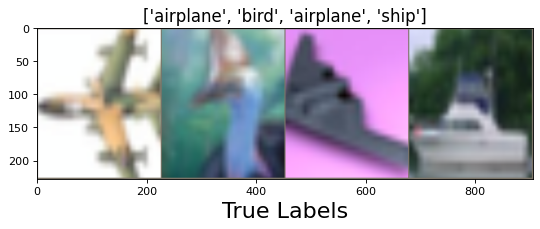

In [ ]:
def imshow(inp, ax=None,title=None,xlab=None,size=(8,2.5)):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    #fig, ax = plt.subplots(figsize=size)
    plt.figure(num=None, figsize=size, dpi=80,edgecolor='k')
    plt.imshow(inp,aspect='auto')
    plt.xlabel(xlab,fontsize=20)
    if title is not None:
      plt.title(title,size=15)
    plt.pause(0.001)  # pause a bit so that plots are updated
    #plt.title(title)
    #plt.show()

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes],xlab='True Labels')

###Training Function

In [ ]:
def train_model(model, criterion, optimizer, scheduler=None, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            #if phase == 'train':
            #    scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

### Plotting Predictions

In [ ]:
def visualize_plots(model,boolean,cls):
  counter = 0
  wrong_inputs,correct_class,predicted_class = [],[],[]
  class_correct = list(0. for i in range(10))
  class_total = list(0. for i in range(10))
  with torch.no_grad():

    for i, (inputs, labels) in enumerate(testloader):
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      c = (preds == labels).squeeze()
      
      for i in range(4):
        if c[i]==boolean and labels.data[i]==cls:
          counter+=1
          wrong_inputs.append(inputs.cpu().data[i])
          correct_class.append(class_names[labels[i]])
          predicted_class.append(class_names[preds[i]])
    #imshow(inputs.cpu().data[i],
    #title='Correct Class:{} | Predicted Class:{}'.format(class_names[labels[i]],class_names[preds[i]]))
      if counter==5:
            #wrong_inputs,correct_class,predicted_class = [],[],[]
        break
  out = torchvision.utils.make_grid(wrong_inputs)
  if boolean==True:
    imshow(out, 
           title=predicted_class,
           xlab='Correct Predictions of {} | Test Accuracy: {}'.format(correct_class[0],test_acc[cls]))
  else:
    imshow(out,
           title=predicted_class,
           xlab='Incorrect Predictions of {} | Test Accuracy: {}'.format(correct_class[0],test_acc[cls]))

### Function:Accuracy by Class

In [ ]:
def div(a,b):
  return a/b

def acc(dataLoader,model_conv):
  class_correct = list(0. for i in range(10))
  class_total = list(0. for i in range(10))
  with torch.no_grad():
    for data in testloader:
      images, labels = data
      outputs = model_conv(images.to(device))
      _, predicted = torch.max(outputs, 1)
      c = (predicted == labels.to(device)).squeeze()
      for i in range(4):
        label = labels[i]
        class_correct[label] += c[i].item()
        class_total[label] += 1
  for i in range(10):
    print('Testing Accuracy of %5s : %2d %%' % (class_names[i], 100 * class_correct[i] / class_total[i]))
  return list(map(div, class_correct,class_total))

#Feature Extraction

In [ ]:
lr = 0.001 #learning rate
weight_decay = 0.0 # l2 regularizer

model_FE = torchvision.models.resnet18(pretrained=True)
for param in model_FE.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_FE.fc.in_features
model_FE.fc = nn.Linear(num_ftrs, 10)

model_FE = model_FE.to(device)

criterion = nn.CrossEntropyLoss()
#Optimizing final layer only
optimizer_FE = optim.SGD(model_FE.fc.parameters(), lr=lr, weight_decay=weight_decay)#, momentum=0.9)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

##Model Training

In [ ]:
model_FE = train_model(model_FE, criterion, optimizer_FE,num_epochs=5)

Epoch 0/4
----------
train Loss: 1.3442 Acc: 0.5545


##Perfromance of model on Test data

In [ ]:
acc(testloader,model_FE)

NameError: ignored

##Correct Predictions

In [ ]:
#fig, axes = plt.subplots(5, 2)
for i in range(10):
  visualize_model(model_FE,True,i)

NameError: ignored

##Incorrect Predictions

In [ ]:
for i in range(10):
  visualize_model(model_FE,False,i)
  plt.show()

NameError: ignored

#Fine Tuning

In [ ]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 10)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

#References


*   Data Loading ->https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
*   Major Chunk ->https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html



data -- a 10000x3072 numpy array of uint8s. Each row of the array stores a 32x32 colour image. The first 1024 entries contain the red channel values, the next 1024 the green, and the final 1024 the blue. The image is stored in row-major order, so that the first 32 entries of the array are the red channel values of the first row of the image.
labels -- a list of 10000 numbers in the range 0-9. The number at index i indicates the label of the ith image in the array data.
Deciding on which layer to extract from is a bit of a science, but something to keep in mind is that early layers in the network are usually learning high-level features such as ‘image contains fur’ or ‘image contains round object’, while lower-level features are more specific to the training data. The ‘avgpool’ layer selected here is at the end of ResNet-18, but if you plan to use images that are very different from ImageNet, you may benefit in using an ealier layer or fine-tuning the model.



# ResNet

*Author: Pytorch Team*

**Deep residual networks pre-trained on ImageNet**

<img src="https://pytorch.org/assets/images/resnet.png" alt="alt" width="50%"/>

In [ ]:
#https://towardsdatascience.com/resnets-for-cifar-10-e63e900524e0
#https://becominghuman.ai/extract-a-feature-vector-for-any-image-with-pytorch-9717561d1d4c
#https://towardsdatascience.com/pytorch-layer-dimensions-what-sizes-should-they-be-and-why-4265a41e01fd